In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

import torch
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePredictive

In [2]:
data = pd.read_csv("input/data-aircon.txt")

In [3]:
data.head()

,X,Y
0,-2.1,98.2
1,-1.9,109.3
2,-1.3,95.4
3,-1.4,93.5
4,-1.3,95.5


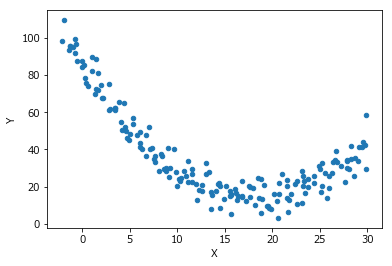

In [4]:
data.plot(kind="scatter", x="X", y="Y")

In [5]:
X = torch.tensor(data.X)
y = torch.tensor(data.Y)

## モデル式

$$\mu_i = a + b (X_i - x)^2$$
$$Y_i \sim Normal(\mu_i, \sigma_i)$$

In [6]:
def model(X, y):
    a = pyro.sample("a", dist.Uniform(0, 100))
    b = pyro.sample("b", dist.Uniform(0, 30))
    x = pyro.sample("x", dist.Uniform(0, 100))
    sigma = pyro.sample("sigma", dist.Uniform(0, 100))
    
    mu = a + b * torch.pow(X - x, 2)
    with pyro.plate("data", len(X)):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=y)

In [7]:
kernel = NUTS(model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
posterior = MCMC(kernel, num_chains=4, num_samples=1000, warmup_steps=1000).run(X, y)

In [8]:
sites = ["a", "b", "x", "sigma"]
marginal = pd.DataFrame(EmpiricalMarginal(posterior, sites)._get_samples_and_weights()[0].reshape(-1, len(sites)).numpy(), columns=sites)

In [9]:
marginal.quantile([0.025, 0.25, 0.5, 0.75, 0.975]).T

,0.025,0.25,0.5,0.75,0.975
a,13.036025,13.800722,14.214298,14.616966,15.357712
b,0.203284,0.210522,0.214207,0.217947,0.224870
x,17.987700,18.170953,18.277542,18.381956,18.583030
sigma,5.162090,5.520159,5.721448,5.947100,6.402715


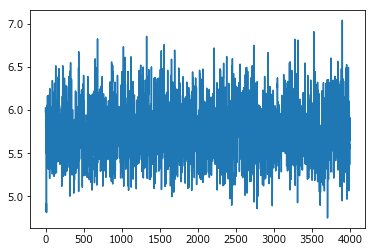

In [10]:
marginal.sigma.plot()

In [11]:
def pred_model(X):
    a = pyro.sample("a", dist.Uniform(0, 100))
    b = pyro.sample("b", dist.Uniform(0, 30))
    x = pyro.sample("x", dist.Uniform(0, 100))
    sigma = pyro.sample("sigma", dist.Uniform(0, 100))
    
    mu = a + b * torch.pow(X - x, 2)
    return pyro.sample("y", dist.Normal(mu, sigma))
predictive = TracePredictive(pred_model, posterior, num_samples=1000).run(torch.arange(-5, 35).float())
predictive_samples = pd.DataFrame(EmpiricalMarginal(predictive, "y")._get_samples_and_weights()[0].numpy())

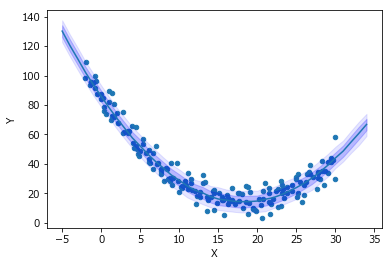

In [12]:
data.plot(kind="scatter", x="X", y="Y")
plt.plot(np.arange(-5, 35), predictive_samples.mean(0).values)
plt.fill_between(np.arange(-5, 35), predictive_samples.quantile(0.1).values, predictive_samples.quantile(0.9).values, color='blue', alpha=0.1)
plt.fill_between(np.arange(-5, 35), predictive_samples.quantile(0.25).values, predictive_samples.quantile(0.75).values, color='blue', alpha=0.2)